In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
import hashlib
import requests
from matplotlib import pyplot as plt
import tqdm as tqdm

In [2]:
# Variables for file and download URL
fname = "condsForSimJ2moMuscles.mat"  # The name of the file to be downloaded
url = "https://osf.io/wak7e/download" # URL from where the file will be downloaded
expected_md5 = "257d16c4d92759d615bf5cac75dd9a1f" # MD5 hash for verifying file integrity

# Check if the file already exists
if not os.path.isfile(fname):
    try:
        # Attempt to download the file
        r = requests.get(url) # Make a GET request to the specified URL
    except requests.ConnectionError:
        # Handle connection errors during the download
        print("!!! Failed to download data !!!")
    else:
        # No connection errors, proceed to check the response
        if r.status_code != requests.codes.ok:
            # Check if the HTTP response status code indicates a successful download
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            # Verify the integrity of the downloaded file using MD5 checksum
            print("!!! Data download appears corrupted !!!")
        else:
            # If download is successful and data is not corrupted, save the file
            with open(fname, "wb") as fid:
                fid.write(r.content) # Write the downloaded content to a file

In [3]:
# Before loading data, check memory usage
import psutil

# Load the .mat file
data = scipy.io.loadmat('condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [3, 4]]  # which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Convert lists of NumPy arrays to single NumPy arrays before conversion to tensors
    go_envelope_np = np.array(go_envelope_condition)
    plan_np = np.array(plan_condition)
    muscle_np = np.array(muscle_condition)

    # Convert the single NumPy arrays to PyTorch tensors
    go_envelope_all.append(torch.tensor(go_envelope_np, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_np, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_np, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Remove the first 70 time steps
go_envelope_tensor = go_envelope_tensor[:, 70:, :]
plan_tensor = plan_tensor[:, 70:, :]
muscle_tensor = muscle_tensor[:, 70:, :]

# Let's print the new shapes to confirm the change
print(f'Go Envelope Tensor Trimmed Shape: {go_envelope_tensor.shape}')
print(f'Plan Tensor Trimmed Shape: {plan_tensor.shape}')
print(f'Muscle Tensor Trimmed Shape: {muscle_tensor.shape}')

# After tensors are created, we no longer need `data` and `conds_for_sim`
del data
del conds_for_sim
# After tensors are reshaped and you no longer need the original ones
del go_envelope_all
del plan_all
del muscle_all
del go_envelope_np
del plan_np
del muscle_np

import gc
gc.collect()

Go Envelope Tensor Trimmed Shape: torch.Size([216, 226, 1])
Plan Tensor Trimmed Shape: torch.Size([216, 226, 15])
Muscle Tensor Trimmed Shape: torch.Size([216, 226, 2])


0

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Normalization and Standardization
def normalize_and_standardize(tensor):
    # Standardize: shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std
    return tensor

# Apply normalization and standardization to go_envelope_tensor and plan_tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Concatenate the input tensors along the last dimension to form the input dataset
inputs = torch.cat((normalized_go_envelope_tensor, normalized_plan_tensor), dim=2)  # should result in a shape of [216, 226, 16]

class TimeseriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]  # shape: [226, 16]
        target_seq = self.targets[idx]  # shape: [226, 2]
        return input_seq, target_seq

# Instantiate the dataset with inputs and targets
full_dataset = TimeseriesDataset(inputs, normalized_muscle_tensor)

# Define the size of each dataset
train_size = int(0.7 * len(full_dataset))  # 70% of data for training
val_size = int(0.15 * len(full_dataset))  # 15% of data for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% of data for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Define the batch size
batch_size = 256

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' using asterisk
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)

            for t in range(inputs.shape[1]):
                # Capture any additional outputs in 'rest' using asterisk
                output, h, *rest = model(inputs[:, t, :], h)
            
            loss = criterion(output, targets[:, -1, :])
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    return avg_test_loss


Epoch 1, Training Loss: 0.7702179551124573
Epoch 1, Validation Loss: 0.42357030510902405
Epoch 2, Training Loss: 0.6905304193496704
Epoch 2, Validation Loss: 0.3592737913131714
Epoch 3, Training Loss: 0.6221401691436768
Epoch 3, Validation Loss: 0.3040018379688263
Epoch 4, Training Loss: 0.5634177923202515
Epoch 4, Validation Loss: 0.2539101839065552
Epoch 5, Training Loss: 0.5101006627082825
Epoch 5, Validation Loss: 0.21069291234016418
Epoch 6, Training Loss: 0.4636355936527252
Epoch 6, Validation Loss: 0.17612963914871216
Epoch 7, Training Loss: 0.426038920879364
Epoch 7, Validation Loss: 0.14526285231113434
Epoch 8, Training Loss: 0.3926812708377838
Epoch 8, Validation Loss: 0.11741684377193451
Epoch 9, Training Loss: 0.3626350164413452
Epoch 9, Validation Loss: 0.09344029426574707
Epoch 10, Training Loss: 0.33657214045524597
Epoch 10, Validation Loss: 0.07423040270805359
Epoch 11, Training Loss: 0.31513068079948425
Epoch 11, Validation Loss: 0.060186006128787994
Epoch 12, Training

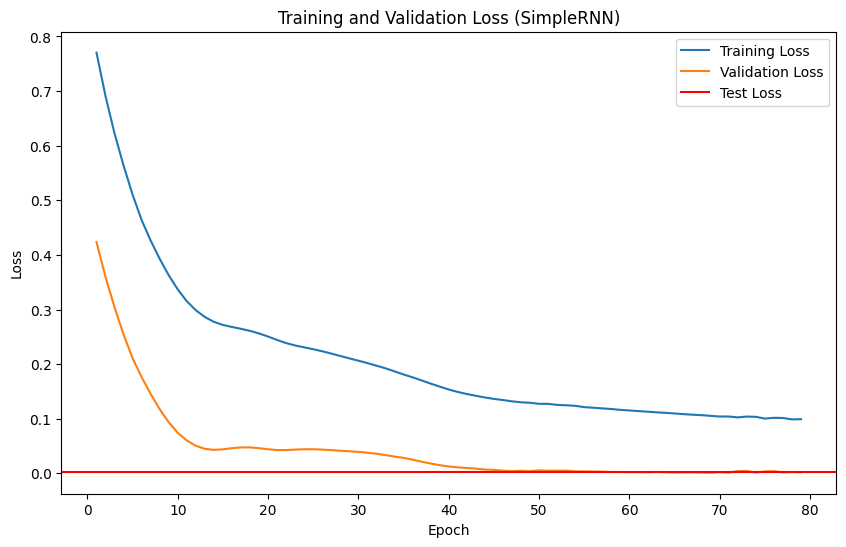

In [6]:
from torch.cuda.amp import autocast, GradScaler
from torch.autograd import profiler

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant
        self.output_linear = nn.Linear(hidden_size, output_size)  # New linear layer

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity
        self.nonlinearity = rectified_tanh 
         
        
    def forward(self, x, hidden):
        hidden_prev = hidden.clone()
        timestep = self.tau / 10  # Timestep for Euler integration    
        # Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1)) 
        input_update = torch.matmul(self.B, x.transpose(0, 1))        
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)    
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)    
        # Output calculation
        output = self.output_linear(firing_rate)    
        # Regularization terms
        firing_rate_reg = hidden.pow(2).sum()
        dynamic_reg = torch.linalg.norm(torch.matmul(self.J, grad_rectified_tanh(hidden.transpose(0, 1))), ord='fro', dim=(-2, -1)).sum()
 
        return output, hidden, firing_rate_reg, dynamic_reg

        
    def init_hidden(self, batch_size):
        # Initialize hidden state with batch dimension
        return torch.zeros(batch_size, self.hidden_size)

def compute_l2_regularization(parameters, alpha):
    l2_reg = sum(p.pow(2.0).sum() for p in parameters)
    return alpha * l2_reg

# Hyperparameters
input_size = 16
hidden_size = 150
output_size = 2  # Number of muscles
g = 1.5  # g value
h_val = 1.0  # h value

# Hyperparameters for regularization
alpha = 1e-4  
beta = 0.03
gamma = 1e-4

# Training Loop
num_epochs = 200
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h_val)
model.to(device)
# Loss Function and Optimizer
criterion = nn.MSELoss()  # MSE Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0) ### WD=0. Note: Paper uses Hessian-Free optimizer
scaler = GradScaler()

for epoch in range(num_epochs):
    hidden_states_for_plot = []
    running_loss = 0.0
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        total_firing_rate_reg = 0
        total_dynamic_reg = 0

        with autocast():  # Enable automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h, firing_rate_reg, dynamic_reg = model(inputs[:, t, :], h)
                total_firing_rate_reg += firing_rate_reg
                total_dynamic_reg += dynamic_reg
                # Append hidden states only in the last epoch
                hidden_states_for_plot.append(h.detach().cpu().numpy())

            # Compute loss and regularization terms
            loss = criterion(output, targets[:, -1, :])
            l2_reg = compute_l2_regularization(model.parameters(), alpha)
            rfr_reg = beta * total_firing_rate_reg / inputs.shape[1] / hidden_size / num_conditions
            rj_reg = gamma * total_dynamic_reg / inputs.shape[1] / num_conditions
            total_loss = loss + l2_reg + rfr_reg + rj_reg

        scaler.scale(total_loss).backward()  # Scale loss and perform backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer
        scaler.update()  # Update scaler

        running_loss += total_loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

# If test_loss was computed, plot it
if 'test_loss' in locals():  # Check if test_loss is defined
    plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (SimpleRNN)')
plt.legend()
plt.show()

Epoch 1, Training Loss: 0.2845151722431183
Epoch 1, Validation Loss: 0.18473997712135315
Epoch 2, Training Loss: 0.20346523821353912
Epoch 2, Validation Loss: 0.12946735322475433
Epoch 3, Training Loss: 0.13223589956760406
Epoch 3, Validation Loss: 0.09767375141382217
Epoch 4, Training Loss: 0.09764936566352844
Epoch 4, Validation Loss: 0.07831057906150818
Epoch 5, Training Loss: 0.07127565890550613
Epoch 5, Validation Loss: 0.052649930119514465
Epoch 6, Training Loss: 0.05145055800676346
Epoch 6, Validation Loss: 0.04397851601243019
Epoch 7, Training Loss: 0.03676040098071098
Epoch 7, Validation Loss: 0.02950039692223072
Epoch 8, Training Loss: 0.029021382331848145
Epoch 8, Validation Loss: 0.029328789561986923
Epoch 9, Training Loss: 0.02716907300055027
Epoch 9, Validation Loss: 0.031505391001701355
Epoch 10, Training Loss: 0.027702027931809425
Epoch 10, Validation Loss: 0.028446296229958534
Epoch 11, Training Loss: 0.02610437385737896
Epoch 11, Validation Loss: 0.026370294392108917


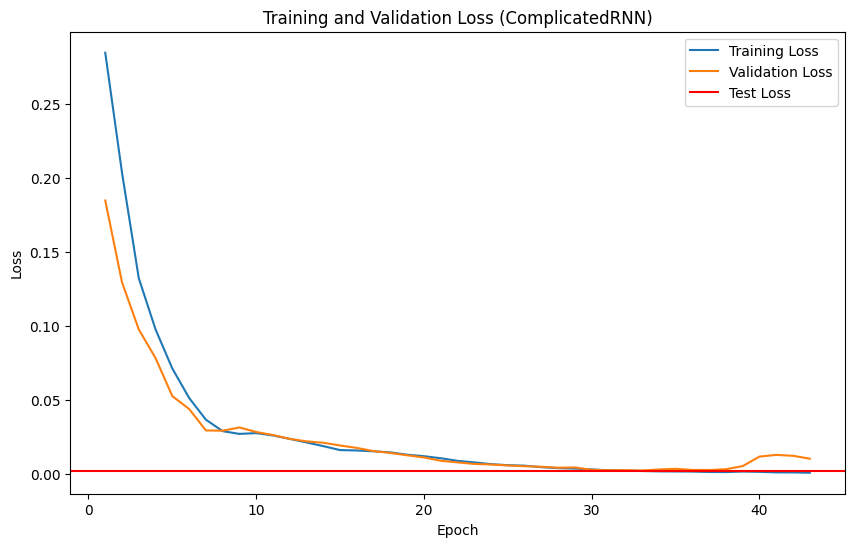

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a custom Rectified Tanh activation function
def rectified_tanh(x):
    return torch.where(x > 0, torch.tanh(x), 0) # was torch.where(x > 0, x, torch.tanh(x))
def grad_rectified_tanh(x):
    return torch.where(x > 0, 1 - torch.tanh(x)**2, 0)
def grad_tanh(x):
    return 1 - torch.tanh(x)**2

# ComplicatedRNN class
class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        self.output_linear = nn.Linear(hidden_size, output_size)

        # Weight initialization (unchanged)
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.bx = nn.Parameter(torch.zeros(hidden_size))

        # Nonlinearity (unchanged)
        self.nonlinearity = rectified_tanh 
        

    def forward(self, x, hidden):
        # Forward pass logic (same as SimpleRNN but without regularization terms)
        hidden_prev = hidden.clone()
        timestep = self.tau / 10
        #Update hidden state
        firing_rate = self.nonlinearity(hidden)        
        hidden_update = torch.matmul(self.J, firing_rate.transpose(0, 1))
        input_update = torch.matmul(self.B, x.transpose(0, 1))     
        new_hidden = hidden_update + input_update + self.bx.unsqueeze(1)
        new_hidden = new_hidden.transpose(0, 1)
        # Euler integration for continuous-time update
        hidden = hidden + (timestep / self.tau) * (-hidden_prev + new_hidden)
        output = self.output_linear(firing_rate)
        
        return output, hidden
        
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Training loop
# Hyperparameters
input_size = 16
hidden_size = 150
output_size = 2  # Number of muscles
g = 4  # g value
h_val = 1.0  # h value

# Training Loop
num_epochs = 300
epoch_losses = [] 
val_losses = []

patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# get available device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Model instantiation
complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h_val)
complicated_model.to(device)

# Loss function and optimizer (no weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(complicated_model.parameters(), lr=0.001, weight_decay=0)
scaler = GradScaler()

# Training loop (updated to remove regularization terms)
for epoch in range(num_epochs):
    running_loss = 0.0
    hidden_states_for_plot_cm = []

    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        h = complicated_model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()

        with autocast():  # Apply automatic mixed precision
            for t in range(inputs.shape[1]):
                output, h = complicated_model(inputs[:, t, :], h)
                hidden_states_for_plot_cm.append(h.detach().cpu().numpy())

            loss = criterion(output, targets[:, -1, :])

        scaler.scale(loss).backward()  # Scale loss for backward pass
        torch.nn.utils.clip_grad_norm_(complicated_model.parameters(), max_norm=1)
        scaler.step(optimizer)  # Update optimizer with scaled gradients
        scaler.update()  # Update the scaler

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_loss}')

    # Validation phase after completing the training for one epoch
    val_loss = validate_model(complicated_model, val_loader, criterion, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered at epoch", epoch + 1)
        early_stop = True
        break

    # Clear CUDA cache if needed
    if device.type == 'cuda':
        torch.cuda.empty_cache()

# Check if training was stopped by early stopping
if early_stop:
    print('Training stopped due to early stopping at epoch', epoch + 1)
else:
    print('Finished Training')
# Testing phase
test_loss = test_model(complicated_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

# Clear cache after training
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
# Determine the number of epochs for which you have loss data
actual_num_epochs = len(epoch_losses)  # This will be less than num_epochs if early stopping was triggered

plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_num_epochs + 1), epoch_losses, label='Training Loss')
plt.plot(range(1, actual_num_epochs + 1), val_losses, label='Validation Loss')

# If test_loss was computed, plot it
if 'test_loss' in locals():  # Check if test_loss is defined
    plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ComplicatedRNN)')
plt.legend()
plt.show()


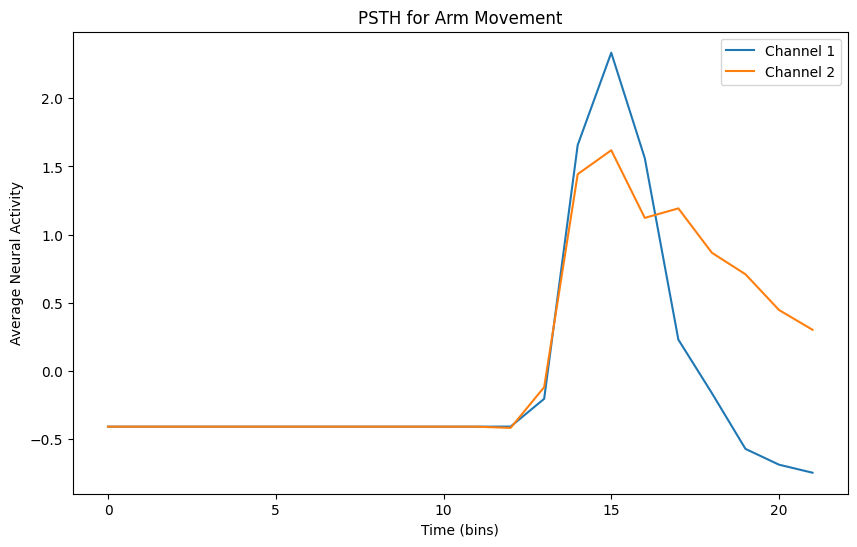

In [8]:
import matplotlib.pyplot as plt
import torch

def plot_psth(data, title, bin_size=10):
    """
    Plot Peri-Stimulus Time Histogram (PSTH) for given data.
    :param data: a tensor containing the neural data
    :param title: a string for the plot title
    :param bin_size: size of time bins for averaging
    """
    # Averaging neural activity across trials for each time bin
    mean_data = data.mean(dim=0)  # Mean across trials
    n_bins = mean_data.shape[0] // bin_size

    # Prepare the data for plotting
    binned_data = mean_data.unfold(0, bin_size, bin_size).mean(dim=2)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(data.shape[2]):  # Iterate over each channel/neuron
        plt.plot(binned_data[:, i], label=f'Channel {i+1}')
    plt.xlabel('Time (bins)')
    plt.ylabel('Average Neural Activity')
    plt.title(title)
    plt.legend()
    plt.show()

plot_psth(normalized_muscle_tensor, "PSTH for Arm Movement")


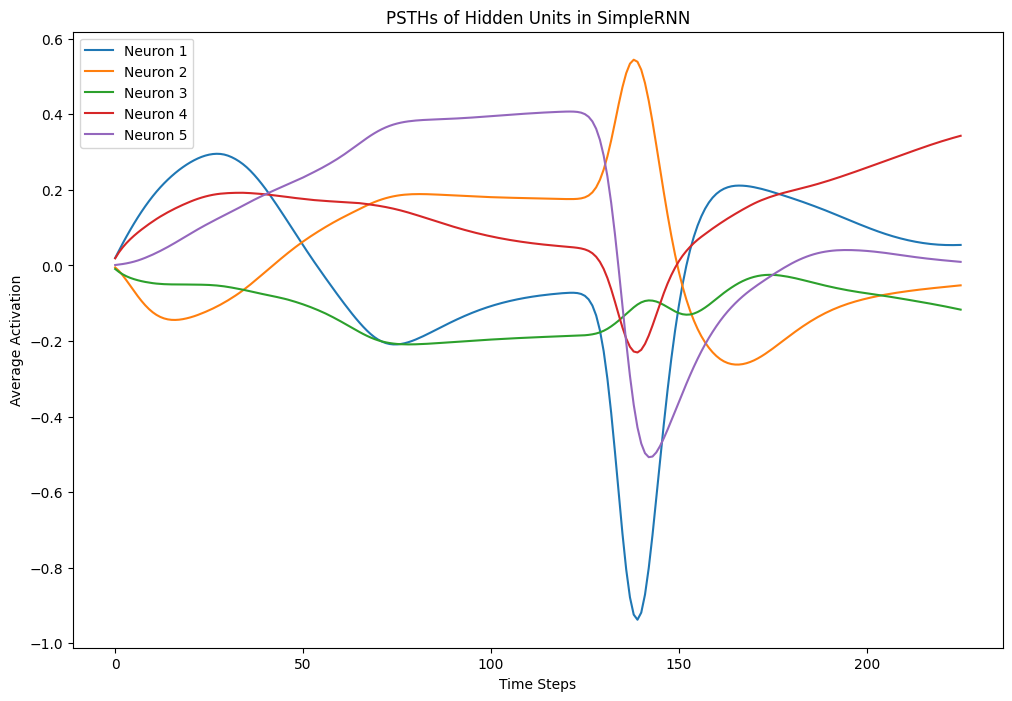

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Convert list of numpy arrays to a single numpy array
hidden_states = np.array(hidden_states_for_plot)

# Calculate the mean across all batches for each time step
# Assuming hidden_states.shape is [num_samples, num_time_steps, hidden_size]
mean_activations = np.mean(hidden_states, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps = mean_activations.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states.shape[2])):
    plt.plot(range(time_steps), mean_activations[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in SimpleRNN')
plt.legend()
plt.show()


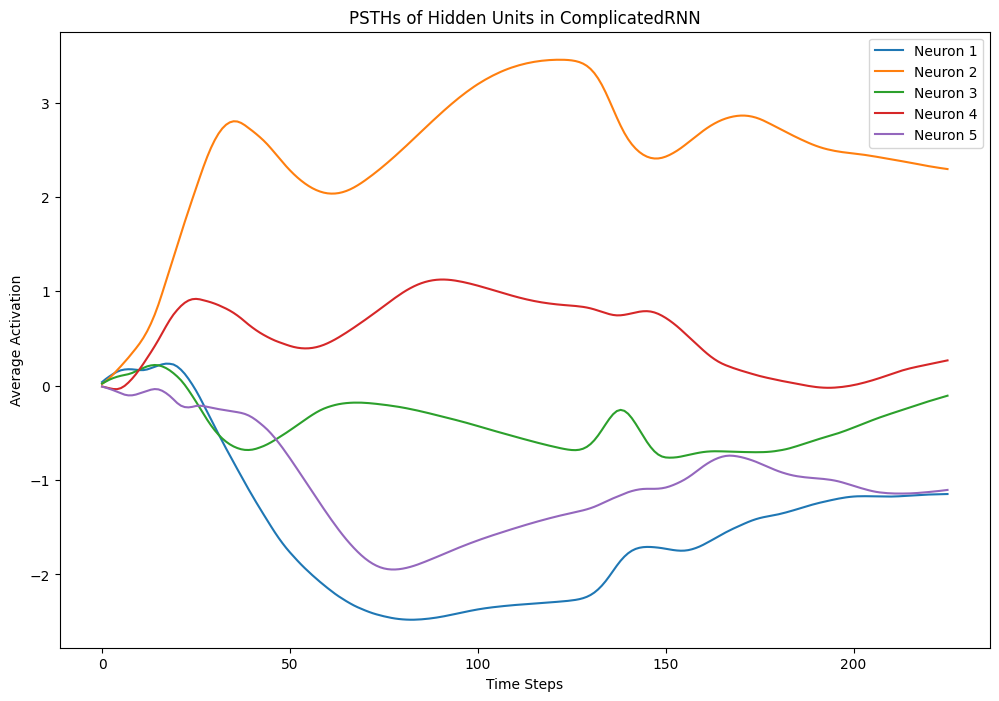

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Convert list of numpy arrays to a single numpy array
hidden_states_cm = np.array(hidden_states_for_plot_cm)

# Calculate the mean across all batches for each time step
# Assuming hidden_states.shape is [num_samples, num_time_steps, hidden_size]
mean_activations_cm = np.mean(hidden_states_cm, axis=1)

# Plot the PSTHs for the first few neurons
neurons_to_plot = 5  
time_steps_cm = mean_activations_cm.shape[0]
plt.figure(figsize=(12, 8))

for i in range(min(neurons_to_plot, hidden_states_cm.shape[1])):
    plt.plot(range(time_steps), mean_activations_cm[:, i], label=f'Neuron {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Activation')
plt.title('PSTHs of Hidden Units in ComplicatedRNN')
plt.legend()
plt.show()


Testing with model: SimpleRNN


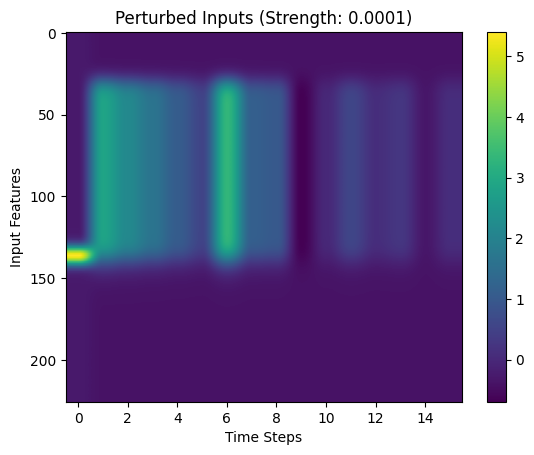

Perturbation strength: 0.0001, Mean Error: 0.12368279423222638
Testing with model: SimpleRNN


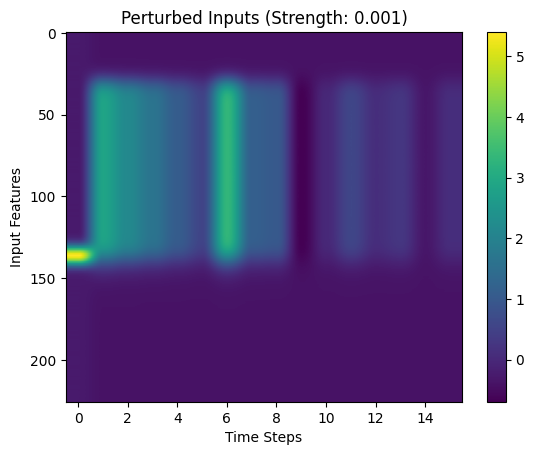

Perturbation strength: 0.001, Mean Error: 0.12368555659164501
Testing with model: SimpleRNN


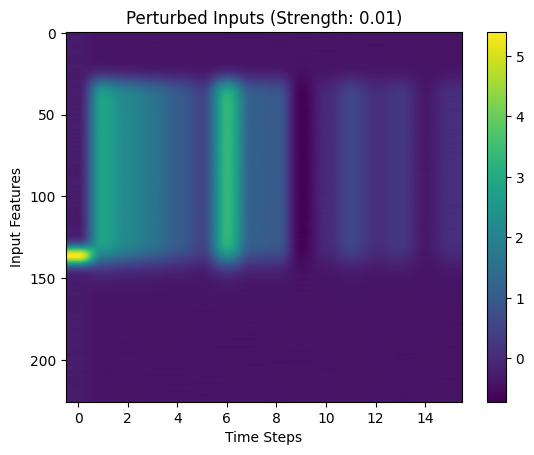

Perturbation strength: 0.01, Mean Error: 0.12368076113444151
Testing with model: SimpleRNN


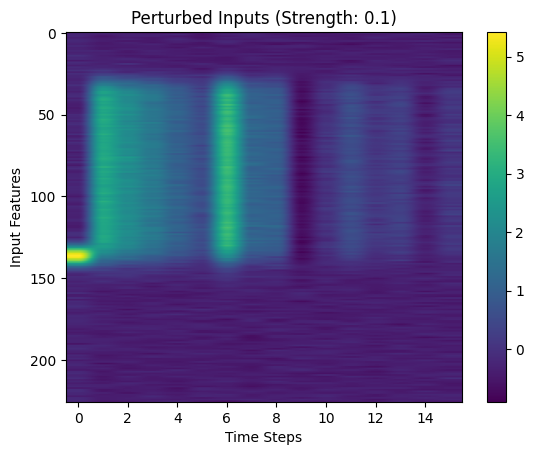

Perturbation strength: 0.1, Mean Error: 0.12409414120628375
Testing with model: SimpleRNN


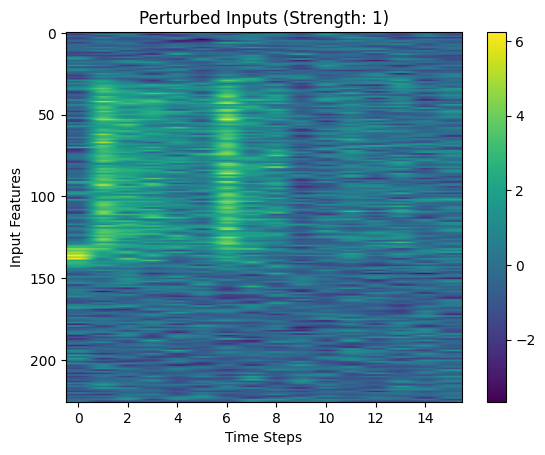

Perturbation strength: 1, Mean Error: 0.1337522087964864
Testing with model: ComplicatedRNN


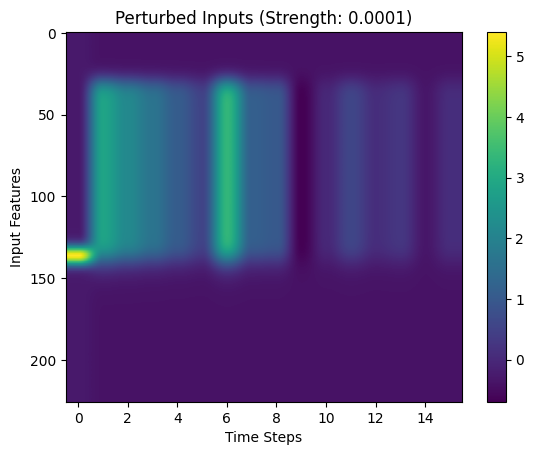

Perturbation strength: 0.0001, Mean Error: 0.12822800378193586
Testing with model: ComplicatedRNN


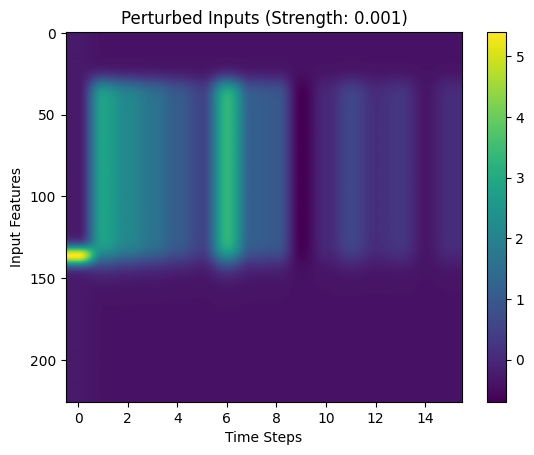

Perturbation strength: 0.001, Mean Error: 0.12822937654703237
Testing with model: ComplicatedRNN


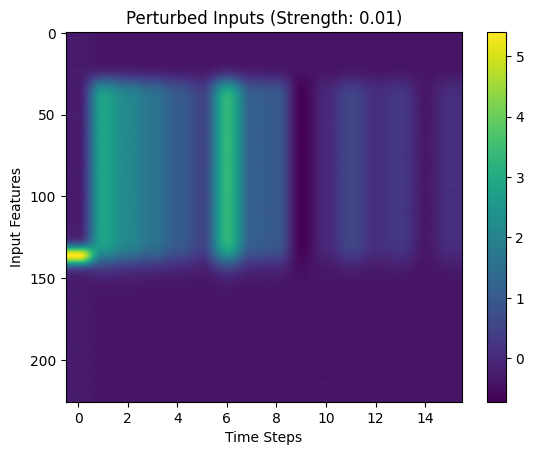

Perturbation strength: 0.01, Mean Error: 0.12820850448235788
Testing with model: ComplicatedRNN


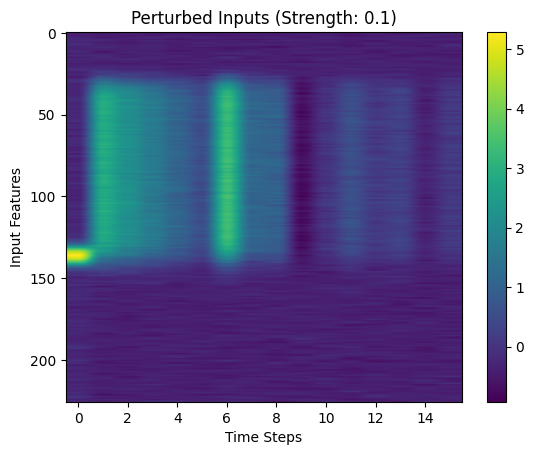

Perturbation strength: 0.1, Mean Error: 0.12839678332489807
Testing with model: ComplicatedRNN


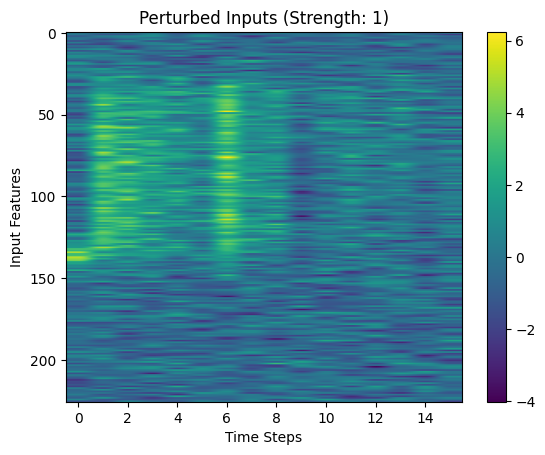

Perturbation strength: 1, Mean Error: 0.12822791676869436
[0.12368279423222638, 0.12368555659164501, 0.12368076113444151, 0.12409414120628375, 0.1337522087964864]
[0.12822800378193586, 0.12822937654703237, 0.12820850448235788, 0.12839678332489807, 0.12822791676869436]


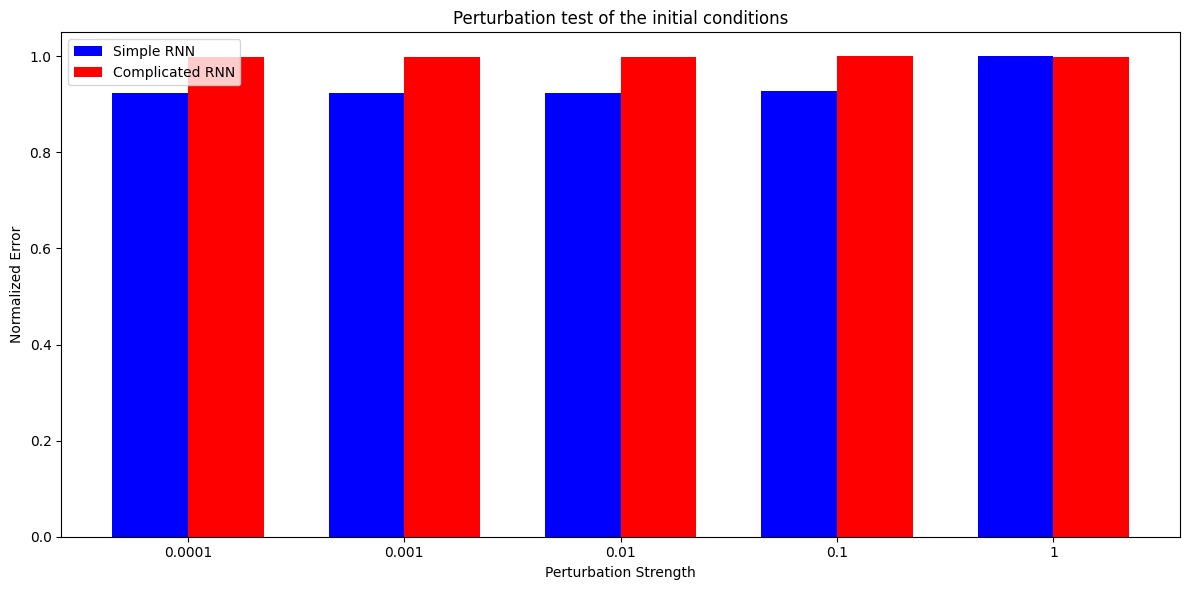

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def perturb_inputs(model, inputs, perturbation_strength):
    # Generate noise
    noise = torch.randn_like(inputs) * perturbation_strength
    # Perturbed inputs
    perturbed_inputs = inputs + noise
    return perturbed_inputs

def test_perturbed_inputs(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors = []


    for strength in perturbation_strengths:
        batch_errors = []  # Store errors for each batch in the test_loader
        outputs_over_time = []  # Store model outputs over time for visualization
        print("Testing with model:", type(model).__name__)  # Print the model type

        for batch_index, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
            
            perturbed_inputs = perturb_inputs(model, inputs, strength)  # Perturb inputs here

            # Plot perturbed inputs for the first batch and the first perturbation strength
            plt.imshow(perturbed_inputs[0].cpu(), aspect='auto')
            plt.colorbar()
            plt.title(f'Perturbed Inputs (Strength: {strength})')
            plt.xlabel('Time Steps')
            plt.ylabel('Input Features')
            plt.show()

            batch_outputs = []  # Store model outputs for this batch over time

            for t in range(inputs.shape[1]):  # Iterate over time steps
                model_output = model(perturbed_inputs[:, t, :], h)
                if len(model_output) == 4:  # If the model returns 4 outputs, unpack all
                    output, h, _, _ = model_output
                else:  # If the model returns 2 outputs, unpack accordingly
                    output, h = model_output
                
                batch_outputs.append(output.cpu().detach().numpy())  # Append the output for this time step

                # Compute loss for the entire sequence (last output)
                loss = criterion(output, targets[:, -1, :]).item()
                batch_errors.append(loss)  # Append the loss of this batch

            outputs_over_time.append(np.array(batch_outputs))  # Store the outputs for this batch

        mean_error = np.mean(batch_errors)  # Calculate mean error for this perturbation strength
        perturbation_errors.append(mean_error)
        print(f'Perturbation strength: {strength}, Mean Error: {mean_error}')

    return perturbation_errors

perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]
simple_model_errors = test_perturbed_inputs(model, perturbation_strengths, train_loader, criterion, device)
complex_model_errors = test_perturbed_inputs(complicated_model, perturbation_strengths, train_loader, criterion, device)
print(simple_model_errors)
print(complex_model_errors)

# Normalize the errors by dividing by the maximum error in each group
max_simple_error = max(simple_model_errors)
max_complex_error = max(complex_model_errors)
simple_model_normalized_errors = [error / max_simple_error for error in simple_model_errors]
complex_model_normalized_errors = [error / max_complex_error for error in complex_model_errors]


# Set the width of the bars
bar_width = 0.35  # Adjust this as needed

# Create an array of indices for the x-axis ticks
x_indices = np.arange(len(perturbation_strengths))

# Plotting
plt.figure(figsize=(12, 6))

# Plot bars for the simple model
plt.bar(x_indices - bar_width/2, simple_model_normalized_errors, width=bar_width, color='blue', label='Simple RNN')

# Plot bars for the complex model
plt.bar(x_indices + bar_width/2, complex_model_normalized_errors, width=bar_width, color='red', label='Complicated RNN')

# Labeling 
plt.xlabel('Perturbation Strength')
plt.ylabel('Normalized Error')
plt.title('Perturbation test of the initial conditions')

# Set custom tick positions and labels on the x-axis
plt.xticks(x_indices, perturbation_strengths)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Perturbation strength: 0.0001, Mean Error: 0.0016834635753184557
Perturbation strength: 0.001, Mean Error: 0.0016800611047074199
Perturbation strength: 0.01, Mean Error: 0.002008057665079832
Perturbation strength: 0.1, Mean Error: 0.1408931165933609
Perturbation strength: 1, Mean Error: 0.1473485380411148
Perturbation strength: 0.0001, Mean Error: 0.0009411340579390526
Perturbation strength: 0.001, Mean Error: 0.0010129371657967567
Perturbation strength: 0.01, Mean Error: 0.007585003040730953
Perturbation strength: 0.1, Mean Error: 0.07751037180423737
Perturbation strength: 1, Mean Error: 0.6971607804298401


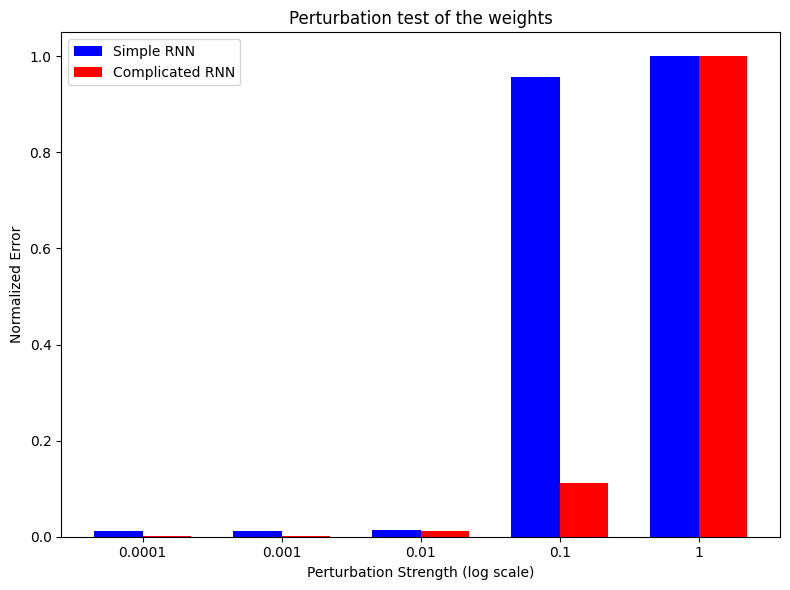

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader

def perturb_recurrent_weights(model, perturbation_strength):
    # Perturb the recurrent weight matrix J by adding Gaussian noise
    with torch.no_grad():
        noise = torch.randn_like(model.J) * perturbation_strength
        perturbed_weights = model.J + noise
        return perturbed_weights

def test_perturbed_structure(model, perturbation_strengths, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    perturbation_errors = []
    original_weights = model.J.data.clone()  # Save the original weights

    for strength in perturbation_strengths:
        batch_errors = []  # Store errors for each batch in the test_loader
        # Perturb the recurrent weights of the model
        perturbed_weights = perturb_recurrent_weights(model, strength)
        model.J.data = perturbed_weights.data

        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size = inputs.size(0)
            h = model.init_hidden(batch_size).to(device)  # Initialize hidden state
            
            for t in range(inputs.shape[1]):  # Iterate over time steps
                model_output = model(inputs[:, t, :], h)
                if len(model_output) == 4:  # If the model returns 4 outputs, unpack all (simple model)
                    output, h, _, _ = model_output
                else:  # If the model returns 2 outputs, unpack accordingly (complicated model)
                    output, h = model_output
            
            # Compute loss for the entire sequence (last output)
            loss = criterion(output, targets[:, -1, :]).item()
            batch_errors.append(loss)  # Append the loss of this batch
        
        # Restore the original weights before the next iteration
        model.J.data = original_weights.data
        
        mean_error = np.mean(batch_errors)  # Calculate mean error for this perturbation strength
        perturbation_errors.append(mean_error)
        print(f'Perturbation strength: {strength}, Mean Error: {mean_error}')
    
    return perturbation_errors

# Define your perturbation strengths
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]

# Get errors for simple and complex models
simple_model_structural_errors = test_perturbed_structure(model, perturbation_strengths, train_loader, criterion, device)
complex_model_structural_errors = test_perturbed_structure(complicated_model, perturbation_strengths, train_loader, criterion, device)

# Normalize the errors by dividing by the maximum error in each group
max_simple_error = max(simple_model_structural_errors)
max_complex_error = max(complex_model_structural_errors)
simple_model_normalized_errors = [error / max_simple_error for error in simple_model_structural_errors]
complex_model_normalized_errors = [error / max_complex_error for error in complex_model_structural_errors]

# Define your perturbation strengths
perturbation_strengths = [0.0001, 0.001, 0.01, 0.1, 1]

# Set the width of the bars
bar_width = 0.35  # Adjust this as needed

# Create an array of indices for the x-axis ticks
x_indices = np.arange(len(perturbation_strengths))

# Plotting
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Plot bars for the simple model
plt.bar(x_indices - bar_width/2, simple_model_normalized_errors, width=bar_width, color='blue', label='Simple RNN')

# Plot bars for the complex model
plt.bar(x_indices + bar_width/2, complex_model_normalized_errors, width=bar_width, color='red', label='Complicated RNN')

# Labeling 
plt.xlabel('Perturbation Strength (log scale)')
plt.ylabel('Normalized Error')
plt.title('Perturbation test of the weights')

# Set custom tick positions and labels on the x-axis
plt.xticks(x_indices, perturbation_strengths)

plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
